 <p style = "font-size: 35px;font-weight: bold;text-align:center;color:#800000"> Ecosure Violations & Review Sentiment All Brands Analysis </p>

<div>
    <img src = "http://upload.wikimedia.org/wikipedia/en/0/0c/Mu_Sigma_Logo.jpg" align="left" style="height:100px;margin-right:100px">
</div>
<div>
    <img src = "https://upload.wikimedia.org/wikipedia/commons/2/26/Ecolab.svg" align="right" style="height:40px;margin-left:100px; margin-top:25px">
</div>

<p style="font-size:100%;text-align:left;font-weight:bold"> Created by  : Mu Sigma team for Ecolab
<p style="font-size:100%;text-align:left;font-weight:bold;"> Last edited : 06/15/2021

 <p style = "font-size: 20px;font-weight: bold;text-align: left;color:#000000"> Description:   </p>
 
This notebook is used to explore the relationship between the drivers and measures. We are comparing audits data with sentiment scores and rating.<br>

Data Used: <br>
* For <b>Audit Information</b>, across different brands, we have used <b>Ecosure BI Data</b> stored in <b>SQLServer</b>
* For <b>Sentiment Information</b>, across different brands, we have used different review sample pulled from <b>Yelp API</b> and run a Sentiment model using Flair

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
import pandas as pd
import numpy as np
import os
import warnings
import itertools
import datetime
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats.stats import pearsonr
from scipy import stats
import matplotlib
import seaborn as sns
import pytz
import pyodbc
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
utc=pytz.UTC
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:.4f}'.format

In [4]:
######################################################### Audit Data ###################################################################
########################################################################################################################################
# read aggregated audit data
df_audit = pd.read_csv('/User/csv/Audit/Ecosure_Processed-0.csv')
df_audit.drop(df_audit.filter(regex="Unname"),axis=1, inplace=True)

# Aggregating data at month year level
df_audit['AuditStarted'] = pd.to_datetime(df_audit['AuditStarted'], errors='coerce')
df_audit = df_audit[df_audit.AuditStarted.notnull()]
df_audit['Date'] = df_audit['AuditStarted'].dt.date

df_audit['month_year'] = df_audit['AuditStarted'].apply(lambda x: x.strftime('%B-%Y'))
df_audit['Total_No_of_Violations_per_question'] = df_audit['Total_Violations']/df_audit['count_questions']

df_audit['Week_Number'] = df_audit['AuditStarted'].dt.week
df_audit['Year'] = df_audit['AuditStarted'].dt.year
df_audit['Week_No_Year'] = df_audit['Week_Number'].astype(str) + '-' + df_audit['Year'].astype(str)

df_violations = df_audit.groupby(['Week_No_Year', 'ClientName'], as_index=False).agg({'Total_No_of_Violations_per_question' : 'mean', 'TranslatedScore' : 'mean', 
                                                                                      'ClientID' : 'count'})

# Renaming Columns
df_violations.rename({'TranslatedScore' : 'Mean_Audit_Score',
                      'ClientName' : 'Brand',
                      'ClientID' : 'No_of_Audits'},axis=1, inplace=True)

In [5]:
print("Total No of unique brands used for analysis:", df_violations.Brand.nunique())
print('\n \n')
print("Name's of the brands used for analysis:", list(df_violations.Brand.unique()))

Total No of unique brands used for analysis: 19

 

Name's of the brands used for analysis: ["Applebee's", 'Buffalo Wild Wings', 'Cafe Zupas', "Friendly's", 'IHOP', 'Noodles & Co.', 'On the Border', 'Panera', 'Benihana National Corp', "O'Charley's, Inc.", 'Margaritaville', 'Ruby Tuesday Inc.', 'True Food Kitchen', 'Twin Peaks', 'WingStop', "Famous Dave's of America,  Inc.", 'Modern Market', 'Wood Ranch', 'Texas Roadhouse']


In [6]:
########################################################## Reviews Data #################################################################
#########################################################################################################################################

# Reading reviews data for yelp and datainfinity
df_panera = pd.read_csv('/User/yelpapi/Sentiment/Panera.csv')
df_panera = df_panera.loc[:, ~df_panera.columns.str.contains('^Unnamed')]
df_panera['Brand'] = 'Panera'

df_panera_di  = pd.read_csv('/User/csv/Panera_Bread.csv')
df_panera_di = df_panera_di.loc[:, ~df_panera_di.columns.str.contains('^Unnamed')]
df_panera_di['Brand'] = 'Panera'

df_ihop  = pd.read_csv('/User/yelpapi/Sentiment/Ihop.csv')
df_ihop = df_ihop.loc[:, ~df_ihop.columns.str.contains('^Unnamed')]
df_ihop['Brand'] = 'IHOP'

df_ihop_di  = pd.read_csv('/User/csv/Ihop.csv')
df_ihop_di = df_ihop_di.loc[:, ~df_ihop_di.columns.str.contains('^Unnamed')]
df_ihop_di['Brand'] = 'IHOP'

df_buffalow = pd.read_csv('/User/yelpapi/Sentiment/Buffalo_Wild_Wings.csv')
df_buffalow = df_buffalow.loc[:, ~df_buffalow.columns.str.contains('^Unnamed')]
df_buffalow['Brand'] = 'Buffalo Wild Wings'

df_buffalow_di = pd.read_csv('/User/csv/Buffalow_Wild_Wings.csv')
df_buffalow_di = df_buffalow_di.loc[:, ~df_buffalow_di.columns.str.contains('^Unnamed')]
df_buffalow_di['Brand'] = 'Buffalo Wild Wings'

df_noodles = pd.read_csv('/User/yelpapi/Sentiment/Noodles.csv')
df_noodles = df_noodles.loc[:, ~df_noodles.columns.str.contains('^Unnamed')]
df_noodles['Brand'] = 'Noodles & Co.'

df_noodles_di = pd.read_csv('/User/csv/Noodles_Company.csv')
df_noodles_di = df_noodles_di.loc[:, ~df_noodles_di.columns.str.contains('^Unnamed')]
df_noodles_di['Brand'] = 'Noodles & Co.'

df_benihana = pd.read_csv('/User/yelpapi/Sentiment/Benihana.csv')
df_benihana = df_benihana.loc[:, ~df_benihana.columns.str.contains('^Unnamed')]
df_benihana['Brand'] = 'Benihana National Corp'

df_benihana_di = pd.read_csv('/User/csv/Benihana.csv')
df_benihana_di = df_benihana_di.loc[:, ~df_benihana_di.columns.str.contains('^Unnamed')]
df_benihana_di['Brand'] = 'Benihana National Corp'

df_ontheboard = pd.read_csv('/User/yelpapi/Sentiment/On_the_border.csv')
df_ontheboard = df_ontheboard.loc[:, ~df_ontheboard.columns.str.contains('^Unnamed')]
df_ontheboard['Brand'] = 'On the Border'

df_ontheboard_di = pd.read_csv('/User/csv/On_the_Border.csv')
df_ontheboard_di = df_ontheboard_di.loc[:, ~df_ontheboard_di.columns.str.contains('^Unnamed')]
df_ontheboard_di['Brand'] = 'On the Border'

df_applebees = pd.read_csv('/User/yelpapi/Sentiment/Applebee.csv')
df_applebees = df_applebees.loc[:, ~df_applebees.columns.str.contains('^Unnamed')]
df_applebees['Brand'] = "Applebee's"

df_applebees_di = pd.read_csv('/User/csv/Applebees.csv')
df_applebees_di = df_applebees_di.loc[:, ~df_applebees_di.columns.str.contains('^Unnamed')]
df_applebees_di['Brand'] = "Applebee's"

df_friendlys = pd.read_csv('/User/yelpapi/Sentiment/Friendlys.csv')
df_friendlys = df_friendlys.loc[:, ~df_friendlys.columns.str.contains('^Unnamed')]
df_friendlys['Brand'] = "Friendly's"

df_friendlys_di = pd.read_csv('/User/csv/Friendlys.csv')
df_friendlys_di = df_friendlys_di.loc[:, ~df_friendlys_di.columns.str.contains('^Unnamed')]
df_friendlys['Brand'] = "Friendly's"

df_margaritaville = pd.read_csv('/User/yelpapi/Sentiment/Margaritaville.csv')
df_margaritaville = df_margaritaville.loc[:, ~df_margaritaville.columns.str.contains('^Unnamed')]
df_margaritaville['Brand'] = 'Margaritaville'

df_margaritaville_di = pd.read_csv('/User/csv/Margaritaville.csv')
df_margaritaville_di = df_margaritaville_di.loc[:, ~df_margaritaville_di.columns.str.contains('^Unnamed')]
df_margaritaville_di['Brand'] = 'Margaritaville'

df_rubytuesday = pd.read_csv('/User/yelpapi/Sentiment/Ruby_Tuesday.csv')
df_rubytuesday = df_rubytuesday.loc[:, ~df_rubytuesday.columns.str.contains('^Unnamed')]
df_rubytuesday['Brand'] = 'Ruby Tuesday Inc.'

df_rubytuesday_di = pd.read_csv('/User/csv/Ruby_Tuesday.csv')
df_rubytuesday_di = df_rubytuesday_di.loc[:, ~df_rubytuesday_di.columns.str.contains('^Unnamed')]
df_rubytuesday_di['Brand'] = 'Ruby Tuesday Inc.'

df_wingstop = pd.read_csv('/User/yelpapi/Sentiment/WingStop.csv')
df_wingstop = df_wingstop.loc[:, ~df_wingstop.columns.str.contains('^Unnamed')]
df_wingstop['Brand'] = 'WingStop'

df_wingstop_di = pd.read_csv('/User/csv/Wing_Stop.csv')
df_wingstop_di = df_wingstop_di.loc[:, ~df_wingstop_di.columns.str.contains('^Unnamed')]
df_wingstop_di['Brand'] = 'WingStop'

df_modmarket = pd.read_csv('/User/yelpapi/Sentiment/Modern_Market.csv')
df_modmarket = df_modmarket.loc[:, ~df_modmarket.columns.str.contains('^Unnamed')]
df_modmarket['Brand'] = 'Modern Market'

df_modmarket_di = pd.read_csv('/User/csv/Modern_Market.csv')
df_modmarket_di = df_modmarket_di.loc[:, ~df_modmarket_di.columns.str.contains('^Unnamed')]
df_modmarket_di['Brand'] = 'Modern Market'

df_truefood = pd.read_csv('/User/yelpapi/Sentiment/True_Food_Kitchen.csv')
df_truefood = df_truefood.loc[:, ~df_truefood.columns.str.contains('^Unnamed')]
df_truefood['Brand'] = 'True Food Kitchen'

df_truefood_di = pd.read_csv('/User/csv/True_Food.csv')
df_truefood_di = df_truefood_di.loc[:, ~df_truefood_di.columns.str.contains('^Unnamed')]
df_truefood_di['Brand'] = 'True Food Kitchen'

df_txroadhouse = pd.read_csv('/User/yelpapi/Sentiment/Texas_Roadhouse.csv')
df_txroadhouse = df_txroadhouse.loc[:, ~df_txroadhouse.columns.str.contains('^Unnamed')]
df_txroadhouse['Brand'] = 'Texas Roadhouse'

df_txroadhouse_di = pd.read_csv('/User/csv/Texas_Roadhouse.csv')
df_txroadhouse_di = df_txroadhouse_di.loc[:, ~df_txroadhouse_di.columns.str.contains('^Unnamed')]
df_txroadhouse_di['Brand'] = 'Texas Roadhouse'

df_famousdave = pd.read_csv('/User/yelpapi/Sentiment/Famous_Dave.csv')
df_famousdave = df_famousdave.loc[:, ~df_famousdave.columns.str.contains('^Unnamed')]
df_famousdave['Brand'] = "Famous Dave's of America,  Inc."

df_famousdave_di = pd.read_csv('/User/csv/Famous_Dave.csv')
df_famousdave_di = df_famousdave_di.loc[:, ~df_famousdave_di.columns.str.contains('^Unnamed')]
df_famousdave_di['Brand'] = "Famous Dave's of America,  Inc."

df_zupas = pd.read_csv('/User/yelpapi/Sentiment/Cafe_Zupas.csv')
df_zupas = df_zupas.loc[:, ~df_zupas.columns.str.contains('^Unnamed')]
df_zupas['Brand'] = 'Cafe Zupas'

df_zupas_di = pd.read_csv('/User/csv/Cafe_Zupas.csv')
df_zupas_di = df_zupas_di.loc[:, ~df_zupas_di.columns.str.contains('^Unnamed')]
df_zupas_di['Brand'] = 'Cafe Zupas'

# df_fourcorners = pd.read_csv('./csv/Four_Corners.csv')
# df_fourcorners = df_fourcorners.loc[:, ~df_fourcorners.columns.str.contains('^Unnamed')]
# df_fourcorners['Brand'] = 'Four Corners Tavern Group'

df_charleys = pd.read_csv('/User/yelpapi/Sentiment/O_Charleys.csv')
df_charleys = df_charleys.loc[:, ~df_charleys.columns.str.contains('^Unnamed')]
df_charleys['Brand'] = "O'Charley's, Inc."

df_charleys_di = pd.read_csv('/User/csv/O_Charleys.csv')
df_charleys_di = df_charleys_di.loc[:, ~df_charleys_di.columns.str.contains('^Unnamed')]
df_charleys_di['Brand'] = "O'Charley's, Inc."

df_twinpeaks = pd.read_csv('/User/yelpapi/Sentiment/Twin_Peaks.csv')
df_twinpeaks = df_twinpeaks.loc[:, ~df_twinpeaks.columns.str.contains('^Unnamed')]
df_twinpeaks['Brand'] = 'Twin Peaks'

df_twinpeaks_di = pd.read_csv('/User/csv/Twin_Peaks.csv')
df_twinpeaks_di = df_twinpeaks_di.loc[:, ~df_twinpeaks_di.columns.str.contains('^Unnamed')]
df_twinpeaks_di['Brand'] = 'Twin Peaks'

df_woodranch = pd.read_csv('/User/yelpapi/Sentiment/Wood_Ranch.csv')
df_woodranch = df_woodranch.loc[:, ~df_woodranch.columns.str.contains('^Unnamed')]
df_woodranch['Brand'] = 'Wood Ranch'

df_woodranch_di = pd.read_csv('/User/csv/Wood_Ranch.csv')
df_woodranch_di = df_woodranch_di.loc[:, ~df_woodranch_di.columns.str.contains('^Unnamed')]
df_woodranch_di['Brand'] = 'Wood Ranch'

df_review = df_panera.append([df_ihop, df_buffalow, df_noodles,
                              df_benihana, df_ontheboard, df_applebees, df_friendlys,
                              df_margaritaville, df_rubytuesday, df_wingstop, df_modmarket,
                              df_truefood, df_txroadhouse, df_famousdave, df_zupas, df_charleys,
                              df_twinpeaks, df_woodranch])

df_review_di = df_panera_di.append([df_ihop_di, df_buffalow_di, df_noodles_di,
                              df_benihana_di, df_ontheboard_di, df_applebees_di, df_friendlys_di,
                              df_margaritaville_di, df_rubytuesday_di, df_wingstop_di, df_modmarket_di,
                              df_truefood_di, df_txroadhouse_di, df_famousdave_di, df_zupas_di, df_charleys_di,
                              df_twinpeaks_di, df_woodranch_di])

df_review = df_review[df_review['date'].notnull()]
# df_review_di = df_review_di[df_review_di['date'].notnull()]

# Getting Month-Year from date
df_review['date'] = pd.to_datetime(df_review['date'], errors='coerce')
df_review['Date'] = df_review['date'].dt.date
df_review['month_year'] = df_review['Date'].apply(lambda x: x.strftime('%B-%Y'))

# Flags to be used in aggregation
def sentiment_check(sentiment, typeofsentiment):
    count = 0
    if(sentiment == typeofsentiment):
        count = 1
    else :
        count = 0
    return count

df_review['Negative_flag'] = df_review.apply(lambda x: sentiment_check(x['Sentiment_Type'], "Negative"), axis=1)
df_review['Positive_flag'] = df_review.apply(lambda x: sentiment_check(x['Sentiment_Type'], "Positive"), axis=1)

df_review_di['Negative_flag'] = df_review_di.apply(lambda x: sentiment_check(x['Sentiment_Type'], "Negative"), axis=1)
df_review_di['Positive_flag'] = df_review_di.apply(lambda x: sentiment_check(x['Sentiment_Type'], "Positive"), axis=1)


df_review['Week_Number'] = df_review['date'].dt.week
df_review['Year'] = df_review['date'].dt.year
df_review['Week_No_Year'] = df_review['Week_Number'].astype(str) + '-' + df_review['Year'].astype(str)

df_grouped_review = df_review.groupby(['Week_No_Year', 'Brand'], as_index=False).agg({'Flair_Score' : 'mean',
                                                                                    'Positive_flag' : 'sum',
                                                                                    'Negative_flag' : 'sum',
                                                                                    'rating' : 'mean',
                                                                                    'text' : 'count'})
df_grouped_review.rename({'text' : 'No_of_Reviews',
                          'rating' : 'Rating',
                          'Positive_flag': 'Positive_Reviews',
                          'Negative_flag': 'Negative_Reviews'}, axis=1, inplace=True)

# Calculating KPIs
df_grouped_review['Positive_Review_Percent'] = (df_grouped_review['Positive_Reviews']/df_grouped_review['No_of_Reviews'])*100
df_grouped_review['Negative_Review_Percent'] = (df_grouped_review['Negative_Reviews']/df_grouped_review['No_of_Reviews'])*100

In [7]:
# print('# of positive and negative reviews for yelp')
df_yelp_brands = df_review.groupby(['Brand'], as_index=False).agg({'Negative_flag' : 'sum', 'Positive_flag' : 'sum'})
df_yelp_brands.rename({"Negative_flag" : "No of Negative Reviews", "Positive_flag" : "No of Positive Reviews"}, axis=1, inplace=True)
df_datafinity_brands = df_review_di.groupby(['Brand'], as_index=False).agg({'Negative_flag' : 'sum', 'Positive_flag' : 'sum'})
df_datafinity_brands.rename({"Negative_flag" : "No of Negative Reviews", "Positive_flag" : "No of Positive Reviews"}, axis=1, inplace=True)

## # of Positive & Negative Reviews Comparison Datafinity vs Yelp

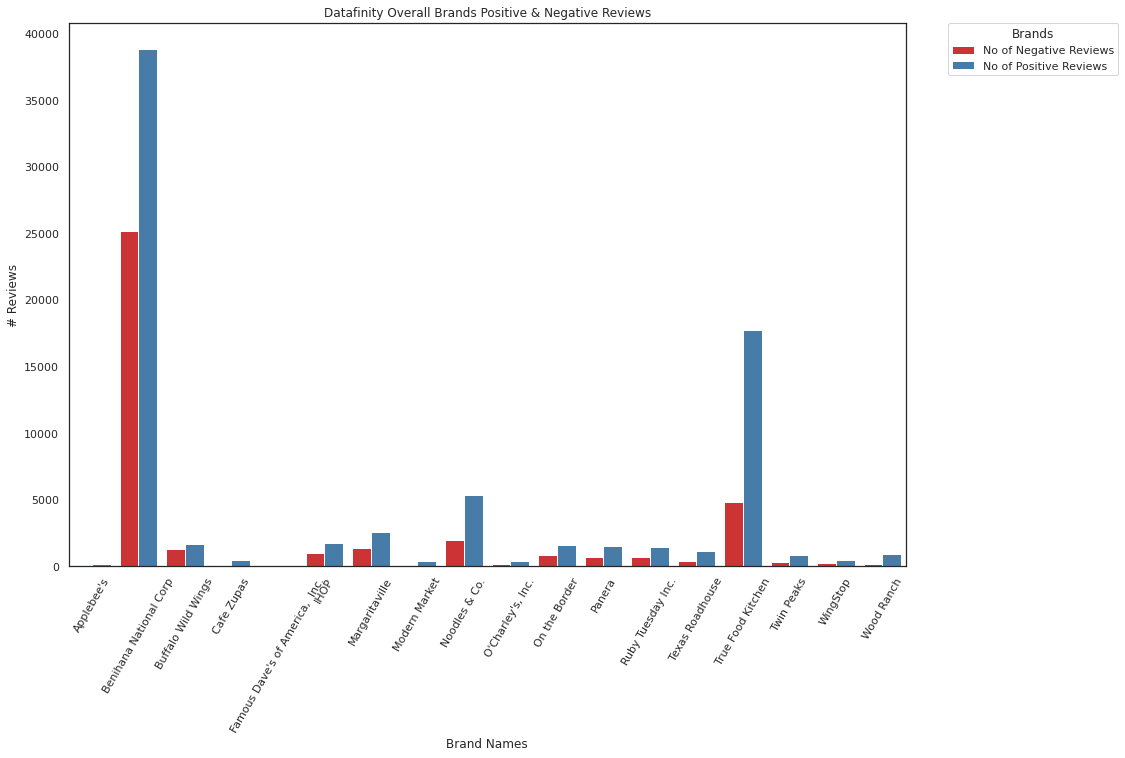

In [8]:
sns.set_context("paper", rc={"font.size":30,"axes.titlesize":30,"axes.labelsize":20})
sns.set(rc={'figure.figsize':(15,10)})
sns.set(style="white", color_codes=True)

ax = sns.barplot(x="Brand", y='value', hue='variable',
                 data=pd.melt(df_datafinity_brands[['Brand', "No of Negative Reviews", "No of Positive Reviews"]], ['Brand']), palette = sns.color_palette("Set1"))
ax.set(xlabel='Brand Names', ylabel='# Reviews', title='Datafinity Overall Brands Positive & Negative Reviews')
plt.xticks(rotation=60)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Brands')
plt.show()

<b> Datafinity Reviews data had more no of positive reviews than negative reviews for the overall 19 brands also the volume of the reviews is very less when compared to yelp <b/>

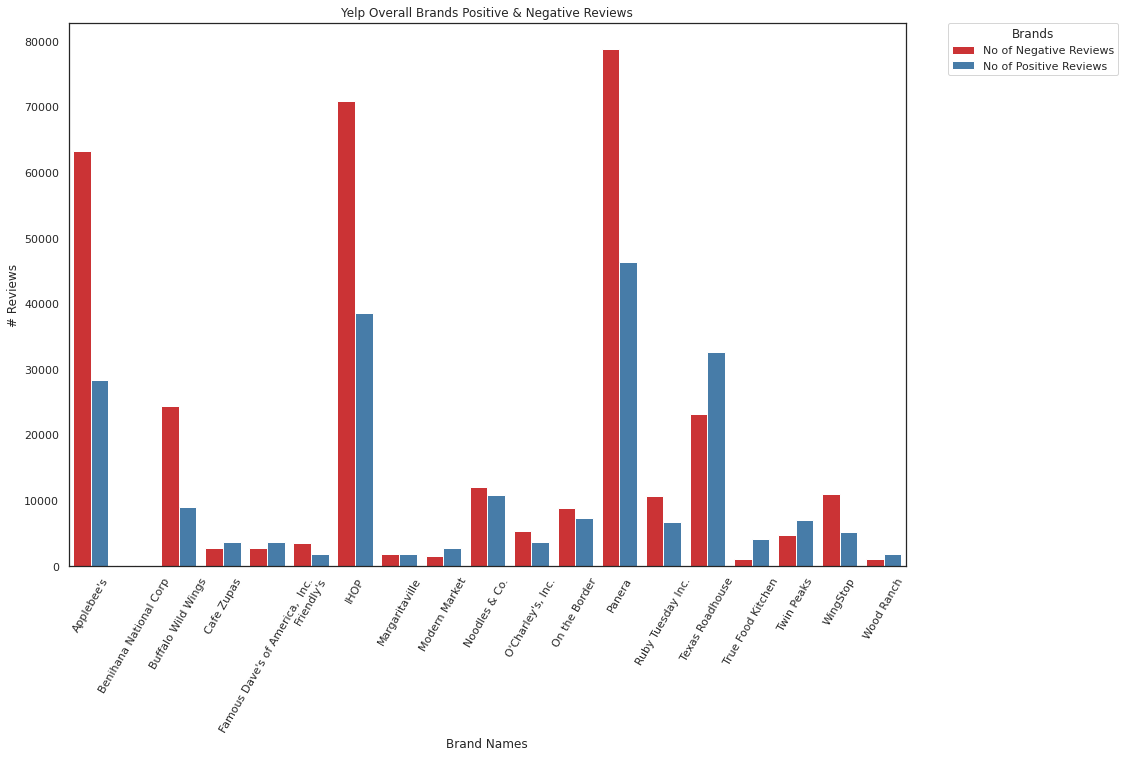

In [9]:
sns.set_context("paper", rc={"font.size":30,"axes.titlesize":30,"axes.labelsize":20})
sns.set(rc={'figure.figsize':(15,10)})
sns.set(style="white", color_codes=True)

ax = sns.barplot(x="Brand", y='value', hue='variable',
                 data=pd.melt(df_yelp_brands[['Brand', "No of Negative Reviews", "No of Positive Reviews"]], ['Brand']), palette = sns.color_palette("Set1"))
ax.set(xlabel='Brand Names', ylabel='# Reviews', title='Yelp Overall Brands Positive & Negative Reviews')
plt.xticks(rotation=60)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Brands')
plt.show()

<b> Yelp Reviews data had more no of negative reviews than positive reviews for the overall 19 brands also the volume of the reviews is also huge when compared to datafinity <b/>

## Ratings Comparison Datafinity vs Yelp

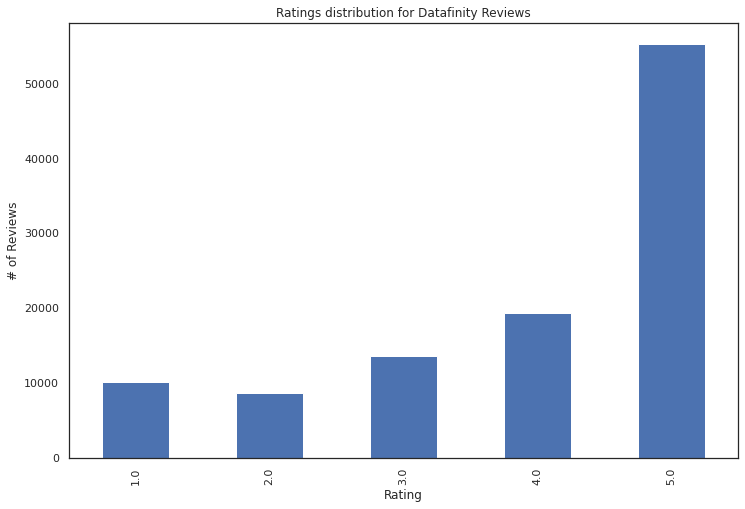

In [10]:
df_review_di = df_review_di.round({"rating": 0})
datafinity_count = df_review_di.rating.value_counts().sort_index()

datafinity_count.plot.bar(figsize=(12, 8))
plt.title('Ratings distribution for Datafinity Reviews')
plt.xlabel('Rating')
plt.ylabel('# of Reviews')
plt.show()

<b> Datafinity Rating had a lot of 5 star rating and very few no of 1, 2 and 3 rating for restaurants for the overall 19 brands<b/>

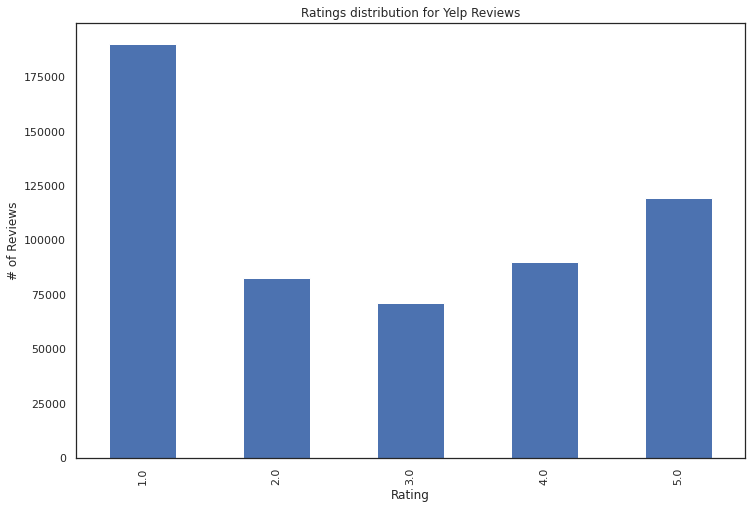

In [11]:
yelp_count = df_review.rating.value_counts().sort_index()

yelp_count.plot.bar(figsize=(12, 8))
plt.title('Ratings distribution for Yelp Reviews')
plt.xlabel('Rating')
plt.ylabel('# of Reviews')
plt.show()

<b> Yelp Rating had a lot of 1 star rating and very few no of 3, 4 rating for restaurants for the overall 19 brands<b/>

## Sentiment (Flair) Score Comparison Data Finity vs Yelp

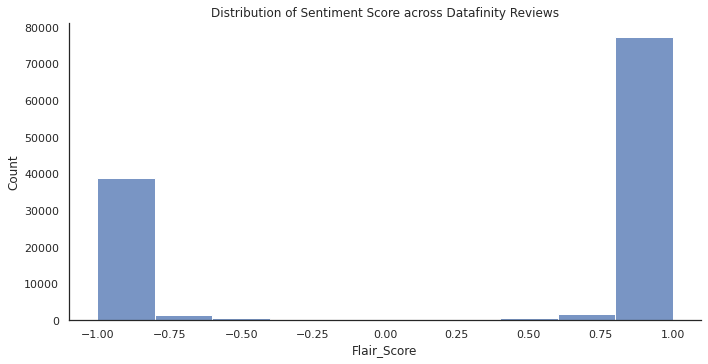

In [12]:
sns.displot(df_review_di, x="Flair_Score", bins=10, fill=True, height=5, aspect=2)
plt.title('Distribution of Sentiment Score across Datafinity Reviews')
plt.show()

<b> Datafinity Sentiment Scores have a lot more positive scores and less negative scores for the overall 19 brands<b/>

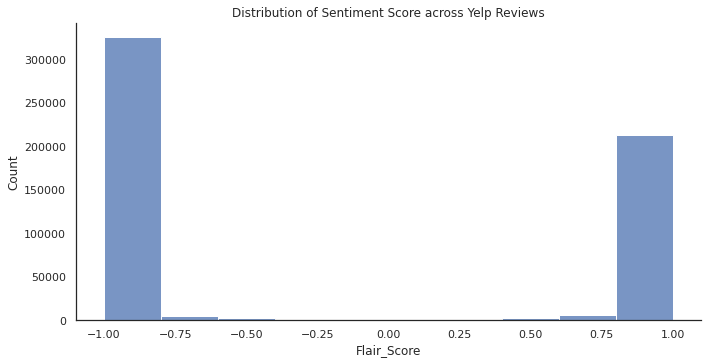

In [13]:
sns.displot(df_review, x="Flair_Score", bins=10, fill=True, height=5, aspect=2)
plt.title('Distribution of Sentiment Score across Yelp Reviews')
plt.show()

<b> Yelp Sentiment Scores have a lot more negative scores and less positive scores for the overall 19 brands<b/>

In [14]:
############################################# Merging Both the Datasets #################################################################
#########################################################################################################################################

df_merged = pd.merge(df_violations, df_grouped_review, how='inner', on=['Week_No_Year', 'Brand'])

# df_merged['month_year'] = pd.Categorical(df_merged['month_year'], categories=new_orders, ordered=True)
# df_merged.sort_values(by=['month_year'], ascending=True, inplace=True)
df_merged.dropna(how = 'any', axis=0, inplace=True)
df_merged.reset_index(drop=True, inplace=True)


# Adding KPI for normalised store
grouped_brands = df_audit.groupby(['ClientName']).agg({'State': pd.Series.nunique ,
                                                       'City': pd.Series.nunique,
                                                       'StoreName':pd.Series.nunique,
                                                       'ClientID': 'count' }).reset_index()
dicti = dict(zip(list(grouped_brands.ClientName), list(grouped_brands.StoreName)))

def kpi_audit_store(brand, audits):
    return (audits/dicti[brand])

df_merged['Audit_per_store'] = df_merged.apply(lambda x: kpi_audit_store(x['Brand'], x['No_of_Audits']), axis=1)

In [15]:
df_grouped = df_merged.groupby(['Brand'], as_index=False).agg({"Flair_Score" : 'mean', "Rating" : 'mean', "Total_No_of_Violations_per_question" : 'mean', "Mean_Audit_Score" : 'mean'})
df_grouped.rename({'Mean_Audit_Score' : 'Average_Translated_Audit_Score'}, axis=1, inplace=True)
df_grouped

,Brand,Flair_Score,Rating,Total_No_of_Violations_per_question,Average_Translated_Audit_Score
0,Applebee's,-0.3881,2.4125,0.0628,85.4530
1,Benihana National Corp,-0.5756,2.0655,0.0357,88.3045
2,Buffalo Wild Wings,-0.5074,2.1741,0.0512,90.5067
3,Cafe Zupas,0.1129,3.4142,0.0908,87.8907
4,"Famous Dave's of America, Inc.",0.5899,3.9064,0.0661,26.9630
5,Friendly's,-0.3742,2.4160,0.0635,91.3379
6,IHOP,-0.3527,2.4169,0.0506,59.2036
7,Margaritaville,0.0216,3.2247,0.0479,94.1375
8,Modern Market,0.0334,3.2676,0.0574,77.9048
9,Noodles & Co.,-0.1830,2.8658,0.0919,79.5414


In [16]:
df_grouped.to_csv("Spreadsheet_View.csv")

In [17]:
######################################################## PLOTS FUNCTIONS ###################################################

def barplots_func(X, Y, DF, X_LABEL, Y_LABEL, TITLE):
    plt.figure(figsize=(10,7))
    ax = sns.barplot(x=X, y=Y, data=DF, palette="deep")
    ax.set(xlabel = X_LABEL, ylabel = Y_LABEL)
    ax.set_title(TITLE)
    plt.xticks(rotation=90)
    plt.show()
    
def dual_ax_plots(X, Y1, Y2, DF, X_LABEL, Y1_LABEL, Y2_LABEL, TITLE):
    plt.figure(figsize=(15,7))
    color = 'darkgreen'
    ax1 = sns.lineplot(x=X, y=Y1, data=DF, color=color, marker='o')
    ax1.set_ylabel(color=color, ylabel='')
    ax1.set(xlabel = X_LABEL, ylabel = Y1_LABEL)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title(TITLE)
    ax1.grid(True)
    plt.xticks(rotation=90)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'darkred'
    ax2 = sns.lineplot(x=X, y=Y2, data=DF, color=color, marker='o')
    ax2.set_ylabel(color=color, ylabel='')
    ax2.set(ylabel = Y2_LABEL)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()
    
def req_intervals(x):
    if (x < -0.5) & (x > -1):
        return 'Score (-0.5 to -1)'
    elif (x < 0) & (x > -0.5):
        return 'Score (-0.5 to 0)'
    elif (x < 0.5) & (x > 0):
        return 'Score (0 to 0.5)'
    else:
        return 'Score (0.5 to 1)'
    

######################################################## FEATURE SELECTION ###################################################

def feature_selction(x_var, y_var, df):
    df_features = df[df.month_year.notnull()]
    X = df_features[x_var]
    y = df_features[y_var]
    ols = LinearRegression()
    ols.fit(X.values, y.values)
    pls = PLSRegression(n_components=6)
    pls.fit(X.values, y.values)
    rf = RandomForestRegressor(n_estimators=20, n_jobs = -1, random_state=42)
    rf.fit(X,y)
    # print('\nBrand Name: ', brand)
    imp_mat = pd.DataFrame({'Features': X.columns, 
                            'Importance_Score_ols': ols.coef_, 
                            'Importance_Score_PLS': pls.coef_.ravel(),
                            'Importance_Score_Random_Forest': rf.feature_importances_
                           })
    display(imp_mat)
    print('\n\n')


######################################################## HYPOTHESIS TESTING ###################################################
    
def spearman_corr(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''
    spearman_corr = []
    null_hypothesis = []
    alternate_hypothsesis = []
    p_val = []
    
    corr, pval = spearmanr(df_datagrouped[test_var],
                            df_datagrouped[measure])
        
    spearman_corr.append(corr)
    p_val.append(pval)
        
    # Accpeted and Rejected interchanged
    if pval < 0.10:
        null_hypothesis.append('Rejected')
        alternate_hypothsesis.append('Accepted')
    else:
        null_hypothesis.append('Accepted')
        alternate_hypothsesis.append('Rejected')

    test_df = pd.DataFrame({'Spearman Coefficient': spearman_corr,
                            'p-value': p_val,
                            'Null Hypothesis': null_hypothesis,
                            'Atlernate Hypothesis': alternate_hypothsesis})
    
    return test_df

def spearman_corr_brand(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''
    brands = list(df_datagrouped.Brand.unique())
    spearman_corr = []
    lengthdata = []
    
    for brand in brands:
        corr,_= pearsonr(df_datagrouped[df_datagrouped.Brand == brand][test_var], 
                         df_datagrouped[df_datagrouped.Brand == brand][measure])
        lengthdata.append(len(df_datagrouped[df_datagrouped.Brand == brand]))
        spearman_corr.append(corr)
    
    test_df = pd.DataFrame({'Brand': brands,
                            'Data Points': lengthdata,
                            'Correlation Coefficient': spearman_corr
                            })
    
    return test_df

######################################################## Correlation Matrix ###########################################################


def correlation_matrix(var, df, title):
    
    # Compute the correlation matrix
    corr_data = df[var]
    sns.set(style="white")
    corr = corr_data.corr()
    corr = corr.round(2)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 150, n=9)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
                annot = True, vmin=-1)

    ax.set_title(title, fontsize=32)
    plt.show()

In [18]:
print("Total No of brands retained :", df_merged.Brand.nunique())
print('\n \n')
print("Name's of the brands used for analysis:", df_merged.Brand.unique())

Total No of brands retained : 19

 

Name's of the brands used for analysis: ["Applebee's" 'Buffalo Wild Wings' 'Cafe Zupas' "Friendly's" 'IHOP'
 'Noodles & Co.' 'On the Border' 'Panera' "O'Charley's, Inc."
 'Benihana National Corp' 'Margaritaville' 'Ruby Tuesday Inc.'
 'True Food Kitchen' 'Twin Peaks' 'WingStop' 'Modern Market' 'Wood Ranch'
 'Texas Roadhouse' "Famous Dave's of America,  Inc."]


# Approach 1: Overall Brand Analysis

## Descriptive Analysis 

Key Message-
* Brands with <b>Lower number of violations</b> have <b>Positive sentiment scores</b>

### Sentiment & Violations/Audit Distribution acrosss brands 1/4

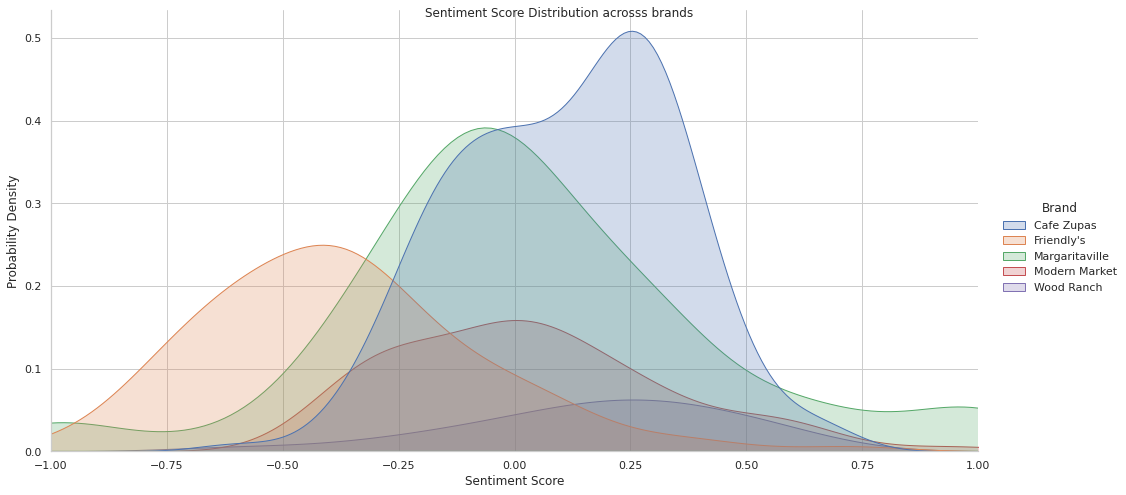

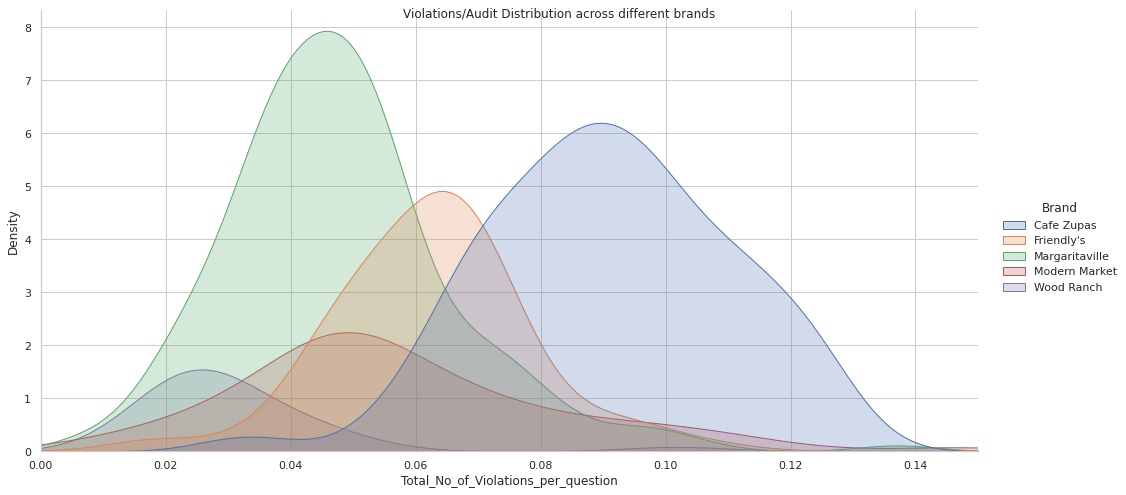

In [19]:
sns.set_style("whitegrid")
ax = sns.displot(data=df_merged[df_merged.Brand.isin(["Friendly's", 'Margaritaville', 'Cafe Zupas', 'Modern Market', 'Wood Ranch'])],
                 x='Flair_Score', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(-1,1))
ax.set(xlabel = 'Sentiment Score', ylabel = 'Probability Density')
ax.fig.suptitle("Sentiment Score Distribution acrosss brands",
                  fontsize=12, fontdict={"weight": "bold"})


ax = sns.displot(data=df_merged[df_merged.Brand.isin(["Friendly's", 'Margaritaville', 'Cafe Zupas', 'Modern Market', 'Wood Ranch'])],
                 x='Total_No_of_Violations_per_question', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(0,0.15))
ax.fig.suptitle("Violations/Audit Distribution across different brands",
                  fontsize=12, fontdict={"weight": "bold"})
plt.show()

### Sentiment & Violations/Audit Distribution acrosss brands 2/4

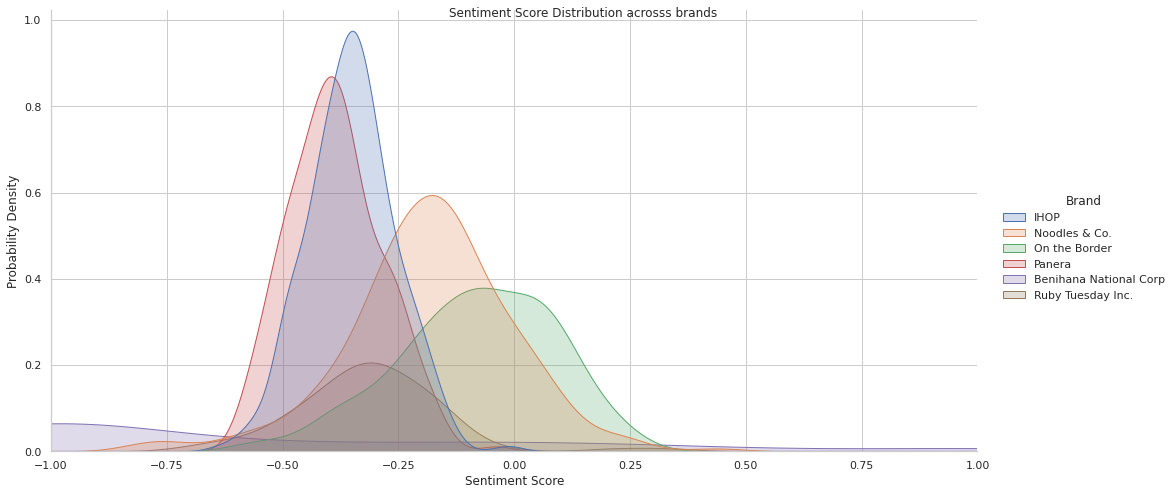

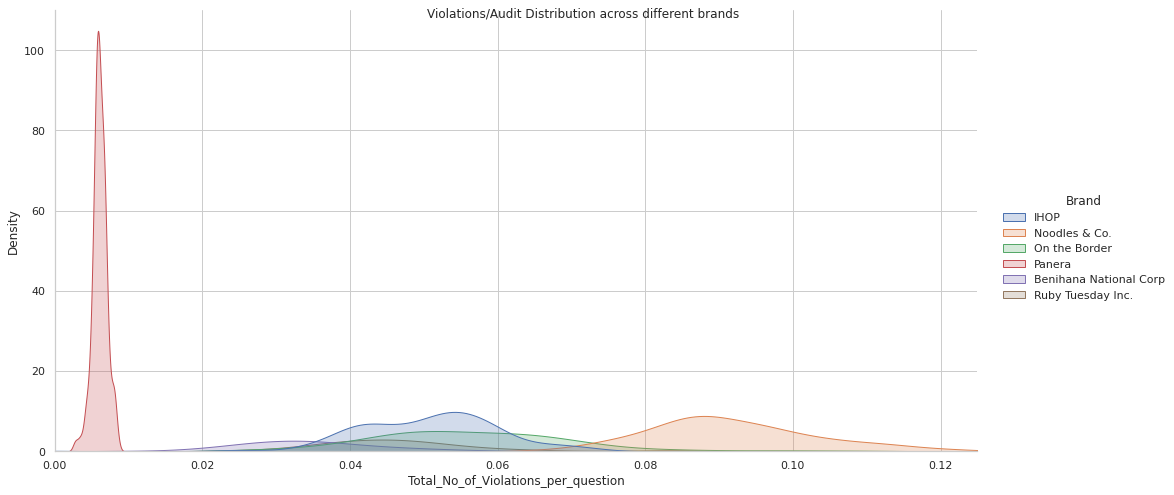

In [20]:
sns.set_style("whitegrid")
ax = sns.displot(data=df_merged[df_merged.Brand.isin(["Benihana National Corp", 'IHOP', 'Noodles & Co.', "On the Border", "Panera", 'Ruby Tuesday Inc.'])],
                 x='Flair_Score', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(-1,1))
ax.set(xlabel = 'Sentiment Score', ylabel = 'Probability Density')
ax.fig.suptitle("Sentiment Score Distribution acrosss brands",
                  fontsize=12, fontdict={"weight": "bold"})


ax = sns.displot(data=df_merged[df_merged.Brand.isin(["Benihana National Corp", 'IHOP', 'Noodles & Co.', "On the Border", "Panera", 'Ruby Tuesday Inc.'])],
                 x='Total_No_of_Violations_per_question', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(0,0.125))
ax.fig.suptitle("Violations/Audit Distribution across different brands",
                  fontsize=12, fontdict={"weight": "bold"})
plt.show()

### Sentiment & Violations/Audit Distribution acrosss brands 3/4

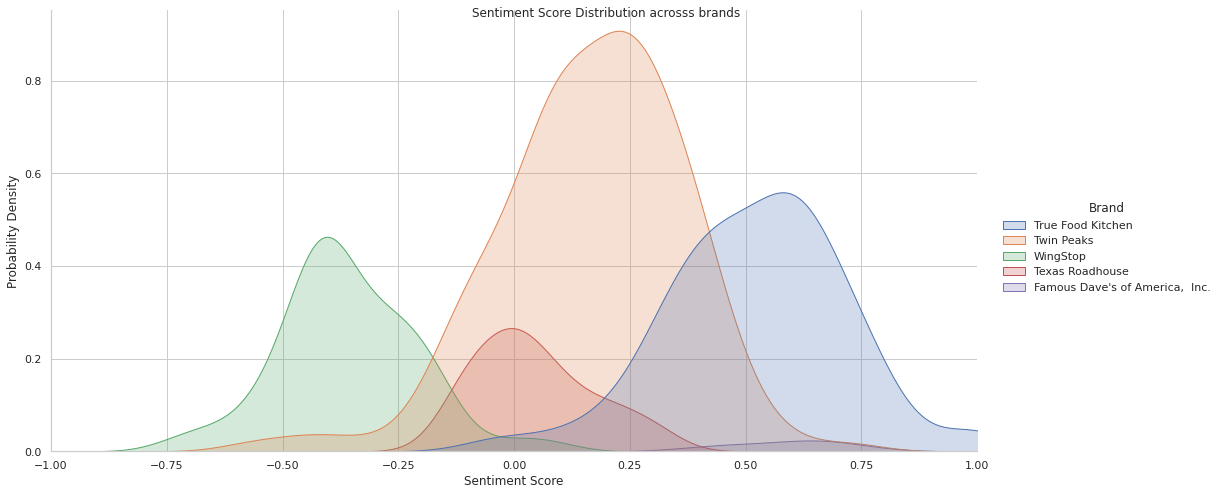

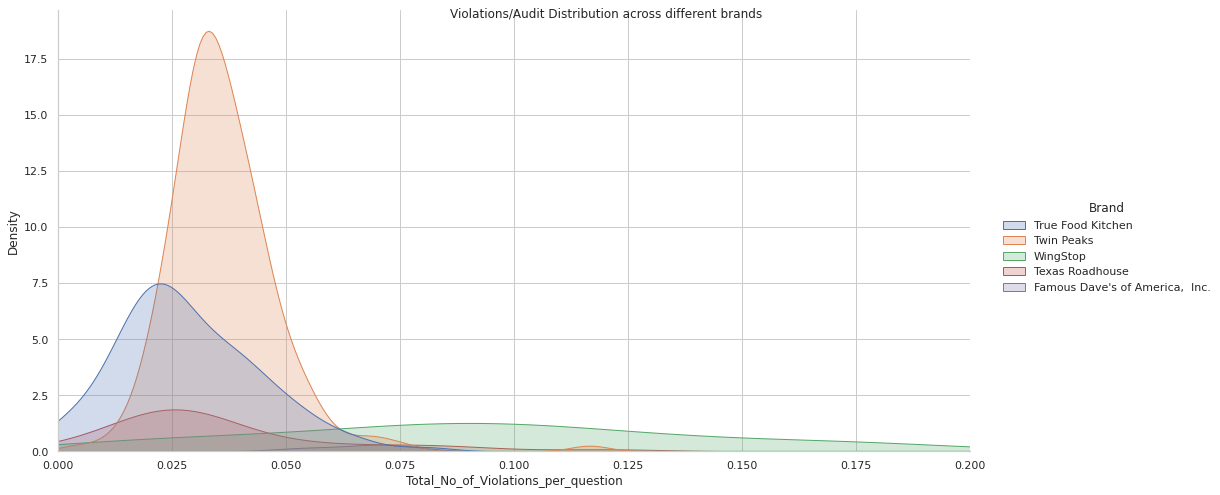

In [21]:
sns.set_style("whitegrid")
ax = sns.displot(data=df_merged[df_merged.Brand.isin(["Famous Dave's of America,  Inc.", 'Four Corners Tavern Group', 'Texas Roadhouse', 'True Food Kitchen', 'Twin Peaks', 'WingStop'])],
                 x='Flair_Score', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(-1,1))
ax.set(xlabel = 'Sentiment Score', ylabel = 'Probability Density')
ax.fig.suptitle("Sentiment Score Distribution acrosss brands",
                  fontsize=12, fontdict={"weight": "bold"})


ax = sns.displot(data=df_merged[df_merged.Brand.isin(["Famous Dave's of America,  Inc.", 'Four Corners Tavern Group', 'Texas Roadhouse', 'True Food Kitchen', 'Twin Peaks', 'WingStop'])],
                 x='Total_No_of_Violations_per_question', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(0,0.2))
ax.fig.suptitle("Violations/Audit Distribution across different brands",
                  fontsize=12, fontdict={"weight": "bold"})
plt.show()

### Sentiment & Violations/Audit Distribution acrosss brands 4/4

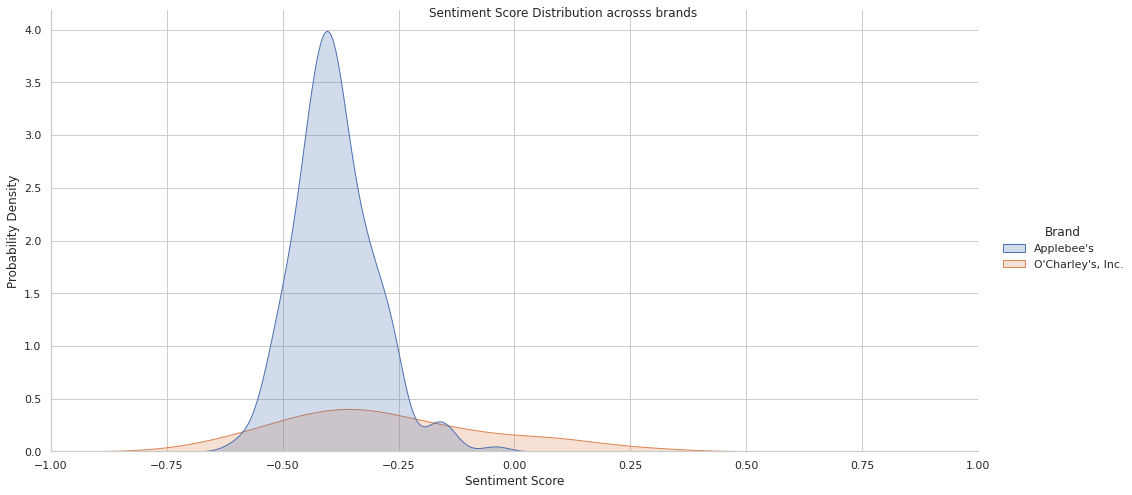

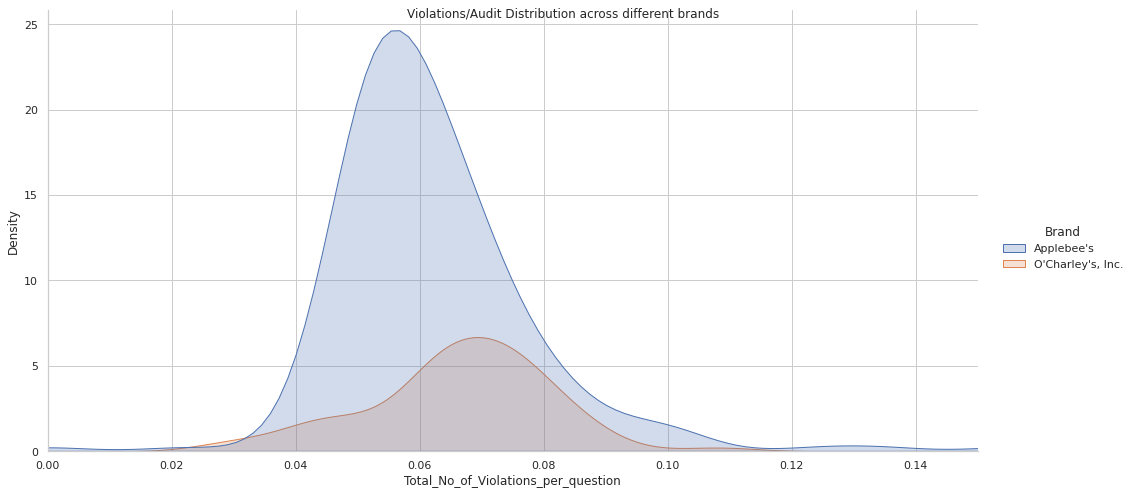

In [22]:
sns.set_style("whitegrid")
ax = sns.displot(data=df_merged[df_merged.Brand.isin(["Applebee's", "O'Charley's, Inc."])],
                 x='Flair_Score', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(-1,1))
ax.set(xlabel = 'Sentiment Score', ylabel = 'Probability Density')
ax.fig.suptitle("Sentiment Score Distribution acrosss brands",
                  fontsize=12, fontdict={"weight": "bold"})


ax = sns.displot(data=df_merged[df_merged.Brand.isin(["Applebee's", "O'Charley's, Inc."])],
                 x='Total_No_of_Violations_per_question', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(0,0.15))
ax.fig.suptitle("Violations/Audit Distribution across different brands",
                  fontsize=12, fontdict={"weight": "bold"})
plt.show()

In [23]:
# df_dist_senti.columns

In [24]:
# def req_intervals(x):
#     if (x < -0.5) & (x > -1):
#         return 'Score (-0.5 to -1)'
#     elif (x < 0) & (x > -0.5):
#         return 'Score (-0.5 to 0)'
#     elif (x < 0.5) & (x > 0):
#         return 'Score (0 to 0.5)'
#     else:
#         return 'Score (0.5 to 1)'

# new_order = ['Score (-0.5 to -1)', 'Score (-0.5 to 0)', 'Score (0 to 0.5)', 'Score (0.5 to 1)']
# df_dist_senti = df_merged.copy()
# # df_dist_senti['Total_No_of_Violations_per_question'] = df_dist_senti['Total_No_of_Violations_per_question']/df_dist_senti['No_of_Reviews']
# df_dist_senti['Flair_Score_bucket'] = df_dist_senti['Flair_Score'].apply(req_intervals)

# plt.figure(figsize=(15,8))
# ax = sns.barplot(x='Flair_Score_bucket', y='Total_No_of_Violations_per_question', data=df_dist_senti, palette = 'deep', order=new_order)
# ax.set(xlabel = 'Sentiment Score Buckets', ylabel = 'Total No of Violations per question')
# ax.set_title('Total No of Violations per question across different sentiment buckets')
# plt.xticks(rotation=30)
# plt.show()

## Approach 2: Brand Level Analysis
### Ranked Correlation Analysis

In [25]:
def spearmanr_corr_brand(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''
    from scipy.stats import spearmanr
    brands = list(df_datagrouped.Brand.unique())
    spearman_corr, p_values = [], []
    lengthdata = []
    
    for brand in brands:
        corr,p = spearmanr(np.array(df_datagrouped[df_datagrouped.Brand == brand][test_var]), 
                         np.array(df_datagrouped[df_datagrouped.Brand == brand][measure]))
        lengthdata.append(len(df_datagrouped[df_datagrouped.Brand == brand]))
        spearman_corr.append(corr)
        p_values.append(p)
    
    test_df = pd.DataFrame({'Brand': brands,
                            'Data Points': lengthdata,
                            'P Values': p_values,
                            'Correlation Coefficient': spearman_corr
                            })
    # inplace
    test_df.replace(np.nan, 0, inplace=True)
    
    return test_df

### Total No of Violations per Question vs Sentiment Score

<b>8 out of the 18 brands show negative correlations with Sentiment Scores </b>

In [26]:
spearmanr_corr_brand(df_merged, 'Total_No_of_Violations_per_question', 'Flair_Score')

,Brand,Data Points,P Values,Correlation Coefficient
0,Applebee's,230,0.9603,0.0033
1,Buffalo Wild Wings,204,0.0000,0.5133
2,Cafe Zupas,182,0.5455,0.0451
3,Friendly's,102,0.4220,0.0804
4,IHOP,231,0.0000,-0.3687
5,Noodles & Co.,242,0.0033,0.1883
6,On the Border,182,0.3803,-0.0654
7,Panera,229,0.0000,0.3567
8,"O'Charley's, Inc.",67,0.2717,0.1362
9,Benihana National Corp,69,0.6680,-0.0526


### Total No of Violations per Question vs Ratings

<b>10 out of the 18 brands show negative correlations with restaurant Ratings </b>

In [27]:
spearmanr_corr_brand(df_merged, 'Total_No_of_Violations_per_question', 'Rating')

,Brand,Data Points,P Values,Correlation Coefficient
0,Applebee's,230,0.9440,-0.0047
1,Buffalo Wild Wings,204,0.0000,0.5149
2,Cafe Zupas,182,0.9949,-0.0005
3,Friendly's,102,0.1359,0.1487
4,IHOP,231,0.0000,-0.3662
5,Noodles & Co.,242,0.0012,0.2068
6,On the Border,182,0.1567,-0.1054
7,Panera,229,0.0000,0.3742
8,"O'Charley's, Inc.",67,0.4302,0.0980
9,Benihana National Corp,69,0.1813,-0.1628


# Approach 3: Across Brands 

Key Messages-
* From Correlation Matrix with Initial Dataset, there is <b> some negative correlation between Violations per Audit and Customer Sentiment Measures</b>
* With more <b>Refined Dataset</b>, the <b>correlation</b> becomes <b> strong between our Drivers(Mean Audit Score, Violations per Audit) and Measures of Delighted Guests(Sentiment Score, Ratings) </b>
* Same relationship is observed across <b>feature importance and hypothesis testing methods</b> as well

In [28]:
def add_lag_lead(df, var_name, brand_name):
    df = df[df['Brand'] == brand_name].reset_index(drop=True)
    df[var_name+"_lag1"] = df[var_name].shift(1)
    df[var_name+"_lead1"] = df[var_name].shift(-1)
    df[var_name+"_lag2"] = df[var_name].shift(2)
    df[var_name+"_lead2"] = df[var_name].shift(-2)
    df[var_name+"_lag3"] = df[var_name].shift(3)
    df[var_name+"_lead3"] = df[var_name].shift(-3)
    
    return df

def add_only_lag_lead(df, var_name):
    df[var_name+"_lag1"] = df[var_name].shift(1)
    df[var_name+"_lead1"] = df[var_name].shift(-1)
    df[var_name+"_lag2"] = df[var_name].shift(2)
    df[var_name+"_lead2"] = df[var_name].shift(-2)
    df[var_name+"_lag3"] = df[var_name].shift(3)
    df[var_name+"_lead3"] = df[var_name].shift(-3)
    
    return df

In [29]:
df_applebee = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', "Applebee's")
df_applebee = add_only_lag_lead(df_applebee, 'Mean_Audit_Score')
df_fd = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', "Famous Dave's of America,  Inc.")
df_fd = add_only_lag_lead(df_fd, 'Mean_Audit_Score')
df_f = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', "Friendly's")
df_f = add_only_lag_lead(df_f, 'Mean_Audit_Score')
df_ihop = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'IHOP')
df_ihop = add_only_lag_lead(df_ihop, 'Mean_Audit_Score')
df_mar = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Margaritaville')
df_mar = add_only_lag_lead(df_mar, 'Mean_Audit_Score')
df_noo = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Noodles & Co.')
df_noo = add_only_lag_lead(df_noo, 'Mean_Audit_Score')
df_otb = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'On the Border')
df_otb = add_only_lag_lead(df_otb, 'Mean_Audit_Score')
df_pan = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Panera')
df_pan = add_only_lag_lead(df_pan, 'Mean_Audit_Score')
df_twi = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Twin Peaks') 
df_twi = add_only_lag_lead(df_twi, 'Mean_Audit_Score')
df_bww = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Buffalo Wild Wings') 
df_bww = add_only_lag_lead(df_bww, 'Mean_Audit_Score')
df_cz = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Cafe Zupas')
df_cz = add_only_lag_lead(df_cz, 'Mean_Audit_Score')
df_ws = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'WingStop')
df_ws = add_only_lag_lead(df_ws, 'Mean_Audit_Score')
df_tr = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Texas Roadhouse')
df_tr = add_only_lag_lead(df_tr, 'Mean_Audit_Score')
df_tfk = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'True Food Kitchen')
df_tfk = add_only_lag_lead(df_tfk, 'Mean_Audit_Score')
df_rt = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Ruby Tuesday Inc.')
df_rt = add_only_lag_lead(df_rt, 'Mean_Audit_Score')
df_oc = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', "O'Charley's, Inc.")
df_oc = add_only_lag_lead(df_oc, 'Mean_Audit_Score')
df_mm = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Modern Market')
df_mm = add_only_lag_lead(df_mm, 'Mean_Audit_Score')
df_beni = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Benihana National Corp')
df_beni = add_only_lag_lead(df_beni, 'Mean_Audit_Score')
df_wr = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Wood Ranch')
df_wr = add_only_lag_lead(df_wr, 'Mean_Audit_Score')

In [30]:
df_merged_1 = df_applebee.append([df_fd, df_f, df_ihop, df_mar,
                                  df_noo, df_otb, df_pan, df_twi,
                                  df_bww, df_cz, df_ws, df_tr,
                                  df_tfk, df_rt, df_oc, df_mm,
                                  df_beni, df_wr])
df_merged_1.dropna(axis=0, how='any', inplace=True)
df_merged_1.reset_index(drop=True, inplace=True)

##  Correlation Matrix for Pilot Brands

### Data Aggregated at Week_No_Year & Brand Level

In [31]:
df_pilot = df_merged_1[(df_merged_1.Brand == 'Modern Market') | (df_merged_1.Brand == 'Texas Roadhouse') | (df_merged_1.Brand == 'True Food Kitchen')]
df_pilot.reset_index(drop=True, inplace=True)

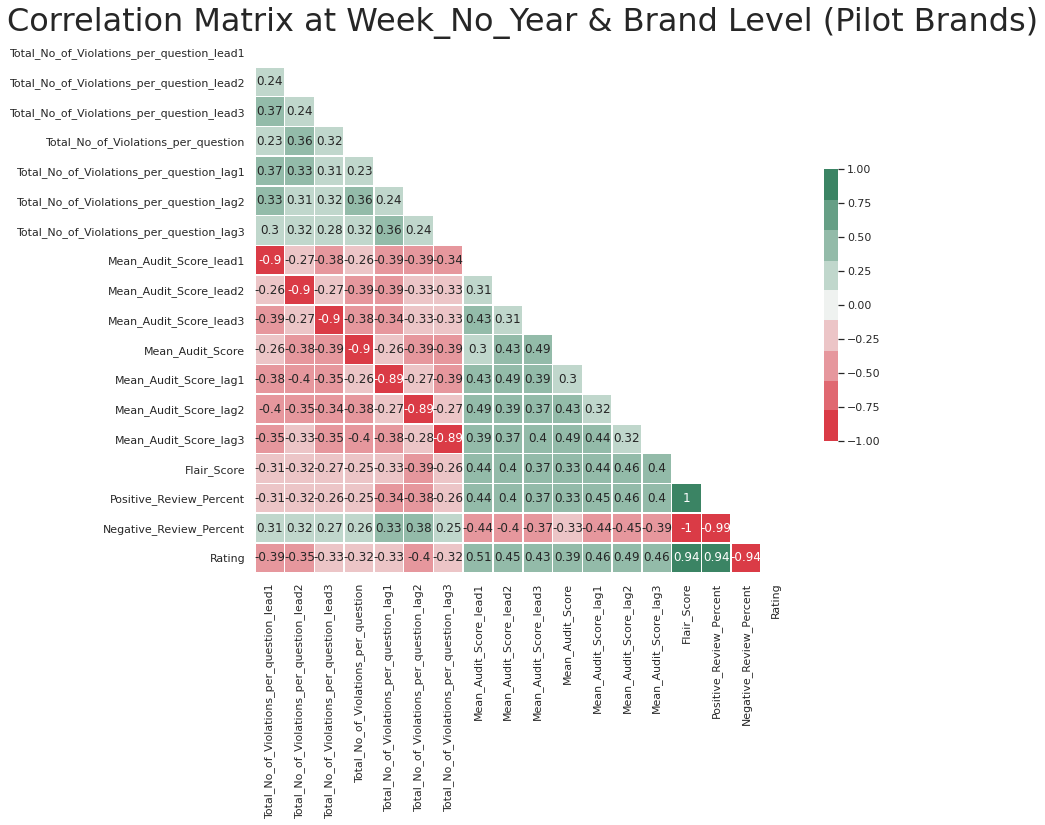

In [32]:
var = ['Total_No_of_Violations_per_question_lead1', 'Total_No_of_Violations_per_question_lead2', 'Total_No_of_Violations_per_question_lead3', 
       'Total_No_of_Violations_per_question', 'Total_No_of_Violations_per_question_lag1', 'Total_No_of_Violations_per_question_lag2', 'Total_No_of_Violations_per_question_lag3',
       'Mean_Audit_Score_lead1', 'Mean_Audit_Score_lead2', 'Mean_Audit_Score_lead3', 'Mean_Audit_Score', 'Mean_Audit_Score_lag1', 'Mean_Audit_Score_lag2', 'Mean_Audit_Score_lag3',  
       'Flair_Score', 'Positive_Review_Percent', 'Negative_Review_Percent', 'Rating']

correlation_matrix(var, df_pilot, "Correlation Matrix at Week_No_Year & Brand Level (Pilot Brands)")

##  Correlation Matrix Pre Covid

### Data Aggregated at Week_No_Year & Brand Level

In [33]:
df_merged_1[['Week_No', 'Year']] = df_merged_1['Week_No_Year'].str.split('-', 1, expand=True)
df_merged_1['Year'] = df_merged_1['Year'].astype(int)
df_precovid = df_merged_1[df_merged_1.Year < 2020]
df_precovid.reset_index(drop=True, inplace=True)

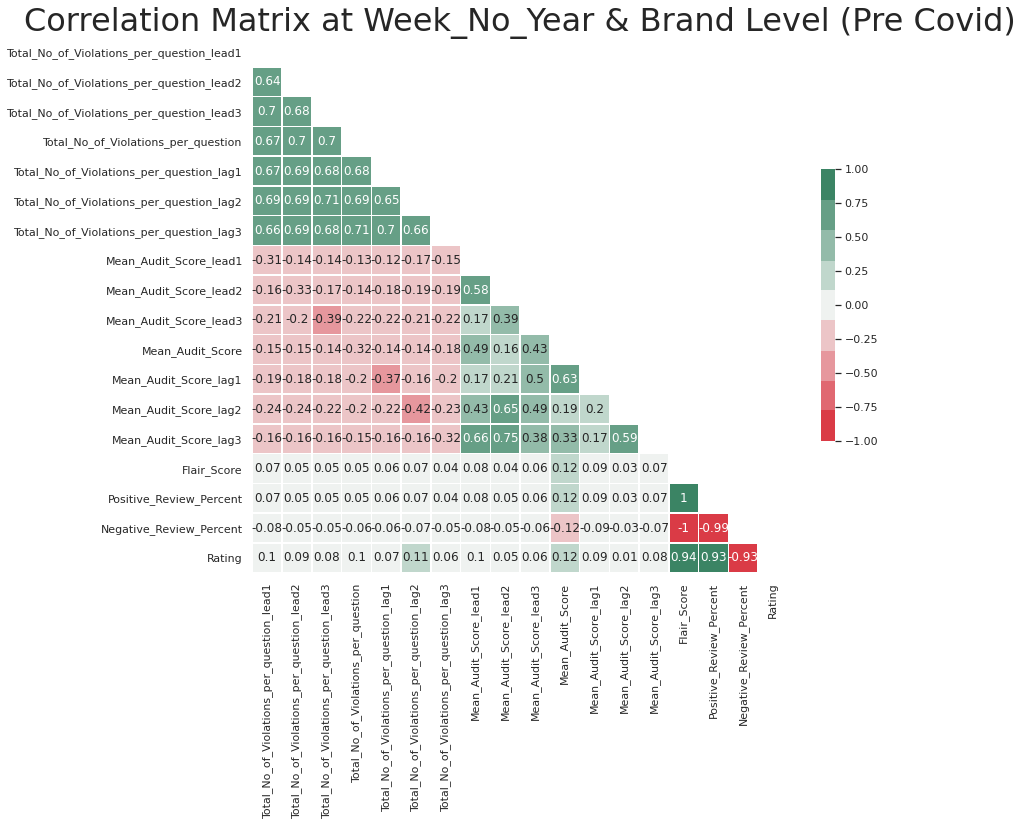

In [34]:
var = ['Total_No_of_Violations_per_question_lead1', 'Total_No_of_Violations_per_question_lead2', 'Total_No_of_Violations_per_question_lead3', 
       'Total_No_of_Violations_per_question', 'Total_No_of_Violations_per_question_lag1', 'Total_No_of_Violations_per_question_lag2', 'Total_No_of_Violations_per_question_lag3',
       'Mean_Audit_Score_lead1', 'Mean_Audit_Score_lead2', 'Mean_Audit_Score_lead3', 'Mean_Audit_Score', 'Mean_Audit_Score_lag1', 'Mean_Audit_Score_lag2', 'Mean_Audit_Score_lag3',  
       'Flair_Score', 'Positive_Review_Percent', 'Negative_Review_Percent', 'Rating']

correlation_matrix(var, df_precovid, "Correlation Matrix at Week_No_Year & Brand Level (Pre Covid)")

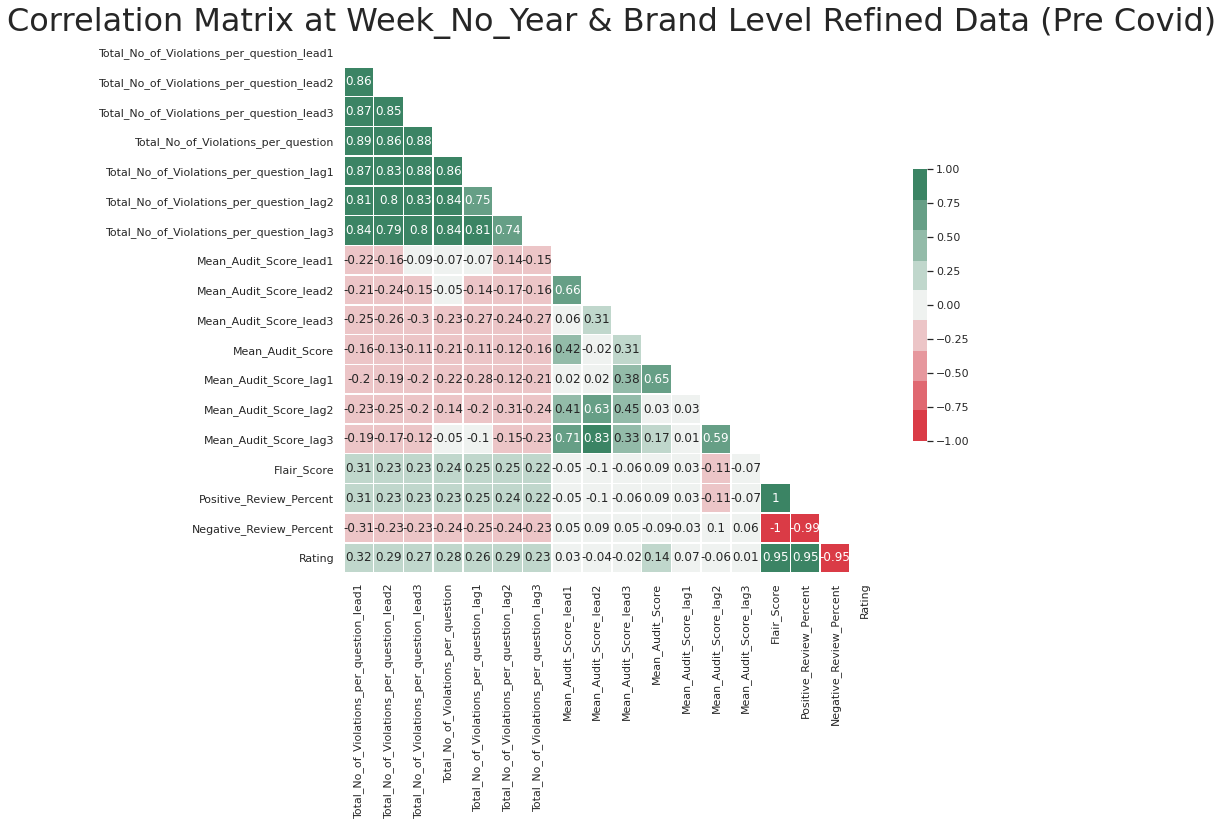

In [35]:
correlation_matrix(var, df_precovid[df_precovid['Flair_Score'].notnull() & (df_precovid.Audit_per_store > df_precovid.Audit_per_store.median()) & (df_precovid.No_of_Reviews > df_precovid.No_of_Reviews.median())], "Correlation Matrix at Week_No_Year & Brand Level Refined Data (Pre Covid)")

<b>Criteria for refining dataset:</b>
* Calculated number of audits (normalised by number of stores per brand)
* Calculated median for Total No of Violations per question and Number of reviews
* Filtered for data points having audits per store and number of reviews greater than median values i.e <b>Total No of Violations per question per Audit > 0.053, No_of_Reviews > 58</b>

In [36]:
print(round(df_precovid.Audit_per_store.median(),3), df_precovid.No_of_Reviews.median())

0.062 58.0


In [37]:
df_precovid[df_precovid['Flair_Score'].notnull() & (df_precovid.Audit_per_store > df_precovid.Audit_per_store.median()) & (df_precovid.No_of_Reviews > df_precovid.No_of_Reviews.median())].shape[0]

369

##  Correlation Matrix for all 19 brands

### Data Aggregated at Week_No_Year & Brand Level (Overall)

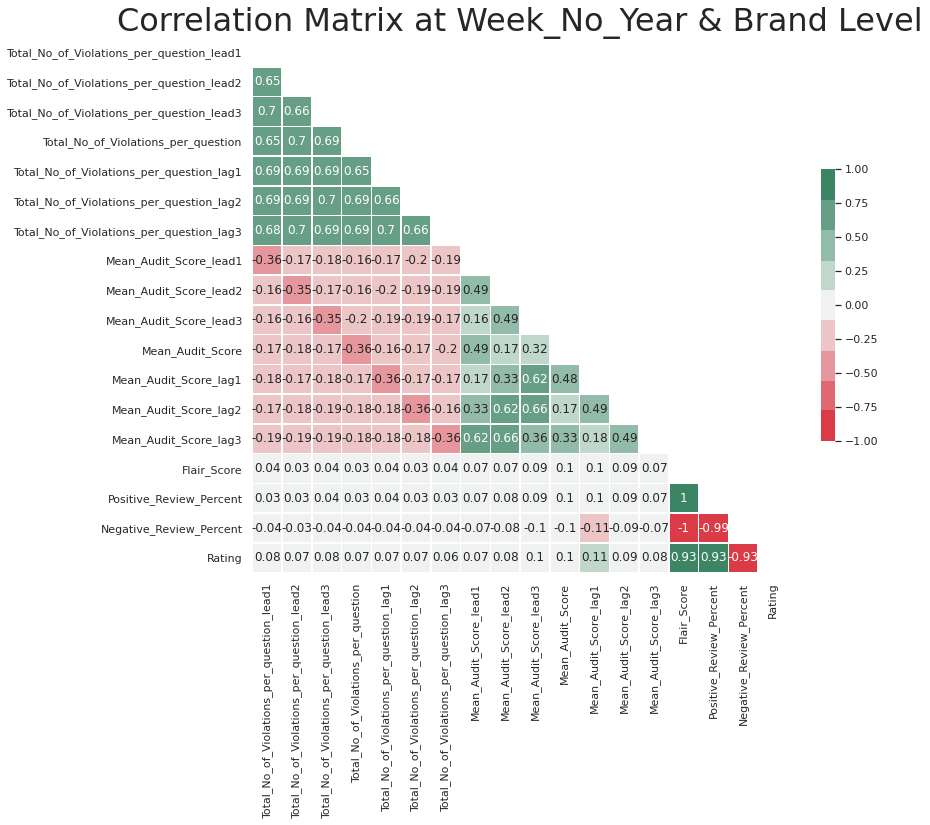

In [37]:
var = ['Total_No_of_Violations_per_question_lead1', 'Total_No_of_Violations_per_question_lead2', 'Total_No_of_Violations_per_question_lead3', 
       'Total_No_of_Violations_per_question', 'Total_No_of_Violations_per_question_lag1', 'Total_No_of_Violations_per_question_lag2', 'Total_No_of_Violations_per_question_lag3',
       'Mean_Audit_Score_lead1', 'Mean_Audit_Score_lead2', 'Mean_Audit_Score_lead3', 'Mean_Audit_Score', 'Mean_Audit_Score_lag1', 'Mean_Audit_Score_lag2', 'Mean_Audit_Score_lag3',  
       'Flair_Score', 'Positive_Review_Percent', 'Negative_Review_Percent', 'Rating']

correlation_matrix(var, df_merged_1, "Correlation Matrix at Week_No_Year & Brand Level")

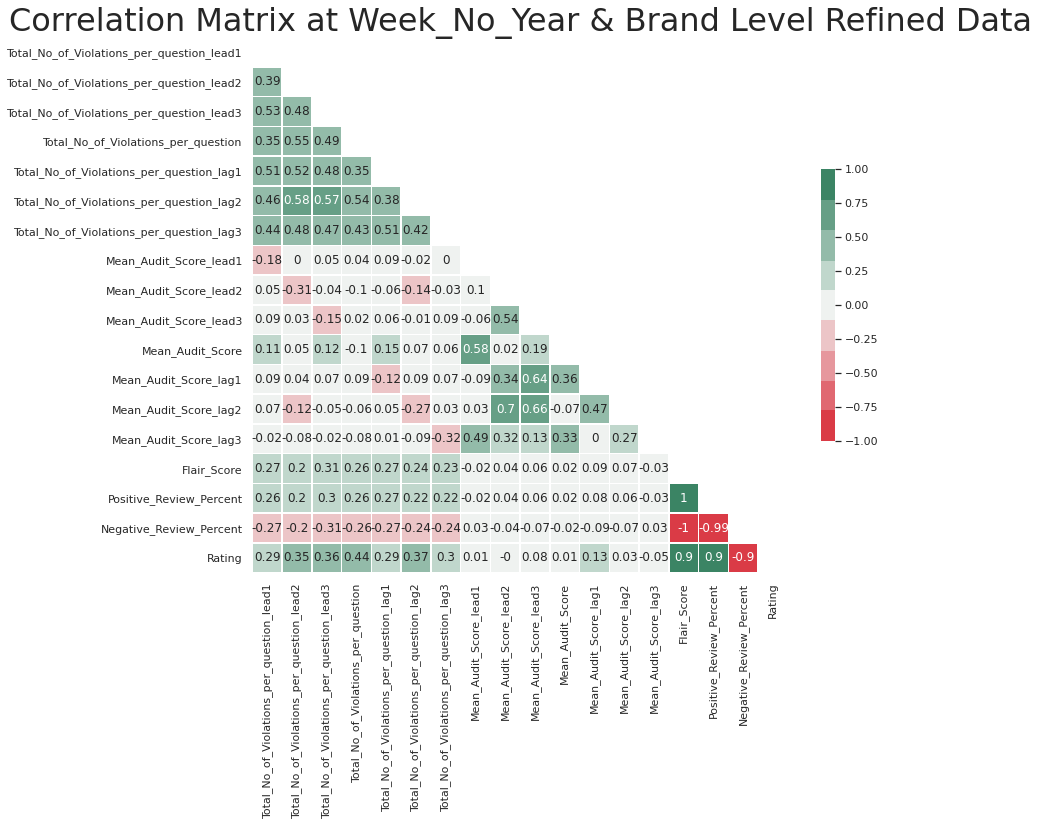

In [38]:
correlation_matrix(var, df_merged_1[df_merged_1['Flair_Score'].notnull() & (df_merged_1.Total_No_of_Violations_per_question > df_merged_1.Total_No_of_Violations_per_question.median()) & (df_merged_1.No_of_Reviews > df_merged_1.No_of_Reviews.median())], "Correlation Matrix at Week_No_Year & Brand Level Refined Data")

<b>Criteria for refining dataset:</b>
* Calculated number of audits (normalised by number of stores per brand)
* Calculated median for Total No of Violations per question and Number of reviews
* Filtered for data points having audits per store and number of reviews greater than median values i.e <b>Total No of Violations per question > 0.052, No_of_Reviews > 54.0</b>

In [41]:
print(round(df_merged.Total_No_of_Violations_per_question.median(),3), df_merged.No_of_Reviews.median())

0.052 54.0


In [42]:
df_merged_1[df_merged_1['Flair_Score'].notnull() & (df_merged_1.Total_No_of_Violations_per_question > df_merged_1.Total_No_of_Violations_per_question.median()) & (df_merged_1.No_of_Reviews > df_merged_1.No_of_Reviews.median())].shape[0]

538

## Hypothesis Testing (Refined Data)

Results-
* <b>Increase in Total No of Violations per Audit, results in decreased Ratings</b>
* <b>Increase in Total No of Violations per Audit, results in decrease in Sentiment Scores</b>



### Hypothesis 1: Total No of Violations per Audit vs Review Ratings
<br>
<b>Null Hypothesis:</b> Increase in Violations per Audit does not affect ratings
 
<b>Alternate Hypothesis:</b> Increase in Violations per Audit, results in decreased ratings

In [43]:
spearman_corr(df_merged_1[df_merged_1['Rating'].notnull() & (df_merged_1.Audit_per_store > df_merged_1.Audit_per_store.median()) & (df_merged_1.No_of_Reviews > df_merged_1.No_of_Reviews.median())], 'Total_No_of_Violations_per_question_lag1', 'Rating')

,Spearman Coefficient,p-value,Null Hypothesis,Atlernate Hypothesis
0,0.2393,0.0000,Rejected,Accepted


### Hypothesis 2: Total No of Violations per Audit vs Sentiment Scores
<br>
<b>Null Hypothesis:</b> Increase in Total No of Violations per Audit does not affect sentiment scores
 
<b>Alternate Hypothesis:</b> Increase in Total No of Violations per Audit, results in decrease in sentiment scores

<b>Spearman Correlation Coefficient</b>

In [44]:
spearman_corr(df_merged_1[df_merged_1['Flair_Score'].notnull() & (df_merged_1.Audit_per_store > df_merged_1.Audit_per_store.median()) & (df_merged_1.No_of_Reviews > df_merged_1.No_of_Reviews.median())], 'Total_No_of_Violations_per_question_lag1', 'Flair_Score')

,Spearman Coefficient,p-value,Null Hypothesis,Atlernate Hypothesis
0,0.2618,0.0000,Rejected,Accepted
